# Clot Burden Prediction

We perform a univariable regression for each target variable and explanatory variable. We then perform multivariable regressions. For these, we focus on body composition only, cardiopulmonary features only, and then a composite model. For each of these, we perform three forms of feature selection, using (1) recursive feature elimination with cross validation, (2) forward sequential feature selection with cross validation, and (3) backward feature selection with cross validation. For these groups of selected features, we also perform sensitivities controlling for gender, age, and both gender and age.

# Imports

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm.notebook import trange, tqdm

# Custom / Lcoal
from config import model_config
from regression import reg

# Stats
from scipy.stats import shapiro
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.metrics import (
    make_scorer, r2_score
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression, LassoCV
)
from sklearn.model_selection import (
	train_test_split, cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Global vars
SEED = 123
TEST_SIZE = 0.25
HEATMAP_COLORS = sns.diverging_palette(h_neg=250, h_pos=359, as_cmap=True)
SIGNIFICANCE_CUTOFF = 0.05
CV_FOLDS = 10

# Cov type
# Options:
#  - robust
#  - clustered
COV_TYPE = 'robust'


# Import/Preprocess Data

In [2]:
with open(Path('../data/prediction_data.pkl'), 'rb') as f:
	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y')
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')
control_features = data.get('controls')
all_features = body_features + cardio_features + control_features

print(X.shape)
print(y.shape)
print(body_features)
print(cardio_features)
print(control_features)

(91, 37)
(91, 21)
['volume_visceral_fat', 'density_visceral_fat', 'mass_visceral_fat', 'volume_subcutaneous_fat', 'density_subcutaneous_fat', 'mass_subcutaneous_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'mass_intermuscular_fat', 'volume_muscle', 'density_muscle', 'mass_muscle', 'volume_bone', 'density_bone', 'mass_bone', 'bmi', 'bsa']
['emphysema_volume_950hu', 'lung_volume', 'extrapulmonary_artery_volume', 'extrapulmonary_vein_volume', 'intrapulmonary_artery_volume', 'intrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5', 'bv10', 'pb_larger_10', 'pv_diameter', 'a_diameter', 'pv_a', 'heart_volume', 'airway_volume', 'airway_ratio', 'ild_volume', 'ild_ratio']
['age', 'gender_cl_Male']


In [3]:
pe_numbers = y.index.str[:-2]
pe_numbers

Index(['PE1', 'PE12', 'PE12', 'PE14', 'PE15', 'PE15', 'PE15', 'PE15', 'PE16',
       'PE16', 'PE17', 'PE18', 'PE18', 'PE18', 'PE18', 'PE19', 'PE2', 'PE20',
       'PE21', 'PE22', 'PE22', 'PE22', 'PE23', 'PE23', 'PE24', 'PE24', 'PE25',
       'PE25', 'PE27', 'PE27', 'PE28', 'PE3', 'PE3', 'PE3', 'PE31', 'PE32',
       'PE32', 'PE32', 'PE32', 'PE33', 'PE34', 'PE34', 'PE36', 'PE36', 'PE37',
       'PE37', 'PE37', 'PE4', 'PE40', 'PE40', 'PE41', 'PE41', 'PE41', 'PE41',
       'PE42', 'PE42', 'PE43', 'PE44', 'PE45', 'PE47', 'PE48', 'PE48', 'PE49',
       'PE5', 'PE51', 'PE51', 'PE51', 'PE52', 'PE52', 'PE52', 'PE52', 'PE52',
       'PE52', 'PE53', 'PE54', 'PE54', 'PE54', 'PE56', 'PE56', 'PE6', 'PE6',
       'PE6', 'PE6', 'PE6', 'PE6', 'PE6', 'PE7', 'PE8', 'PE8', 'PE8', 'PE9'],
      dtype='object')

# OLS Regression Functions

In [4]:
def get_params(model, X, y):
    """Returns pd.Series of coefs for comparison with statsmodels params."""
    model.fit(X, y)
    coef = pd.Series(model.coef_, index=model.feature_names_in_)
    coef['const'] = model.intercept_
    return coef.sort_values()

In [5]:
def model_residual_correlation(model):
    """Returns measure of correlation."""
    return np.corrcoef(np.arange(len(model.resid)), model.resid)[1, 0]

In [113]:
def fit_model(X, y):
    """Fit statsmodels OLS model with robust SEs and sklearn OLS model."""
    # Fit statsmodels model for pvalues and coef
    if COV_TYPE == 'robust':
        model_sm = sm.OLS(y, X).fit(cov_type='HC3')
    elif COV_TYPE == 'clustered':
        model_sm = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': pe_numbers})
    # Define sklearn model for CV evaluation
    model_sk = LinearRegression(fit_intercept=True, n_jobs=-1)
    # Check that model params match
    sk_model_params = get_params(model_sk, X, y)
    sm_model_params = model_sm.params.sort_values()
    params_match = np.isclose(sk_model_params, sm_model_params, atol=1e-5)
    if not np.all(params_match):
        print(f"Regressions on {y.name} did not match for sklearn and statsmodels. CV scores may differ.")
    return model_sm, model_sk

In [7]:
def store_model_results(model_sm, model_sk, X, y):
    """
    Params:
        - model_sm: statsmodel model for coefs, pvalues, and residuals.
        - model_sk: sklearn model for cross validation
        - X: X data.
        - y: y data.
    """
    # Calculate CV scores
    cv_scores = cross_val_score(
        model_sk, X, y, 
        scoring='r2', 
        cv=CV_FOLDS, n_jobs=-1
    )
    # Store model results
    model_results = pd.DataFrame(
        {
            'y': y.name,
            'model_dfn': [tuple(X.columns.values)],
            'nobs': model_sm.nobs,
            'shapiro_resid_pvalue': shapiro(model_sm.resid).pvalue,
            'metric_train': model_sk.score(X, y),
            'metric_cv_mean': np.mean(np.maximum(cv_scores, np.zeros_like(cv_scores))),
            'metric_cv_std': np.std(cv_scores),
        }
    )
    # Set model index
    model_results = model_results.set_index(['y', 'model_dfn'])
    return model_results

In [8]:
def store_coef_results(model_sm, y):
    """
    Params:
        - model_sm: statsmodel model for coefs, pvalues, and residuals.
        - y: y data.
    """
    results = pd.DataFrame(
        {
            'model_dfn': [tuple(model_sm.params.index) for _ in range(len(model_sm.params))],
            'coef': model_sm.params, 
            'pval': model_sm.pvalues,
        },
    )
    results['signif'] = results['pval'].apply(reg.add_significance)
    results = results.reset_index(names='x')
    results['y'] = y.name
    results = results.pivot(index=['y', 'model_dfn'], columns=['x'], values=['coef', 'pval', 'signif'])
    results.columns = ['_'.join(idx) for idx in results.columns]
    return results

In [9]:
def backward_stepwise_selection(X, y, cutoff):
    # Make copies of X, y
    X_temp = sm.add_constant(X.copy())
    y_temp = y.copy()
    
    # Fit initial model
    if COV_TYPE == 'robust':
        model_sm = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
    elif COV_TYPE == 'clustered':
        model_sm = sm.OLS(y_temp, X_temp).fit(cov_type='cluster', cov_kwds={'groups': pe_numbers})
    coefs = model_sm.params[1:]
    pvals = model_sm.pvalues[1:]
    df_temp = pd.DataFrame({
        'coefs': coefs,
        'pvals': pvals
    })
    current_varlist = list(coefs.index.values)

    # Store progression in a list of lists
    progression = list()
    progression.append(dict(zip(coefs.index.values, zip(coefs.values, pvals.values))))
    
    # Iterate until all are stat signif
    while not np.all(df_temp['pvals'] < cutoff):
        
        # Drop the variable with the highest pvalue
        new_vars = df_temp.drop(index=df_temp['pvals'].idxmax()).index.values
        
        # If remaining varlist is empty, break and return the last regression results
        if len(new_vars) == 0:
            break

        # Subset X to new list of variables
        X_temp = sm.add_constant(X_temp.loc[:, new_vars])
        
        # Re-fit model
        model_sm = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
        coefs = model_sm.params[1:]
        pvals = model_sm.pvalues[1:]
        df_temp = pd.DataFrame({
            'coefs': coefs,
            'pvals': pvals
        })
        progression.append(dict(zip(coefs.index.values, zip(coefs.values, pvals.values))))
        current_varlist = [var for var in model_sm.params.index.values if var != 'const']
    
    return current_varlist, progression

# Example
feat_out, prog = backward_stepwise_selection(X[body_features], np.array(y['total_clot_burden']).ravel(), 0.05)
print(feat_out)

['volume_intermuscular_fat', 'mass_intermuscular_fat', 'bsa']


### Example

In [10]:
target = 'total_clot_burden'
features = 'density_visceral_fat'
X_temp = sm.add_constant(X[features])
y_temp = y[target]
model_sm, model_sk = fit_model(X_temp, y_temp)

In [11]:
store_model_results(model_sm, model_sk, X_temp, y_temp)

,,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std
y,model_dfn,,,,,
total_clot_burden,"(const, density_visceral_fat)",91.0,8.131611e-09,0.04507,0.057597,0.217564


In [12]:
store_coef_results(model_sm, y_temp)

,,coef_const,coef_density_visceral_fat,pval_const,pval_density_visceral_fat,signif_const,signif_density_visceral_fat
y,model_dfn,,,,,,
total_clot_burden,"(const, density_visceral_fat)",0.0,-0.212296,1.0,0.05494,,


# Perform univariable regressions

In [13]:
univariate_models = pd.DataFrame()
univariate_coefs = pd.DataFrame()

for target in tqdm(model_config.num_targets):
    for feature in all_features:
        # Fit model
        X_temp = sm.add_constant(X[feature])
        y_temp = y[target]
        model_sm, model_sk = fit_model(X_temp, y_temp)

        # Collect model information
        univariate_models = pd.concat([univariate_models, store_model_results(model_sm, model_sk, X_temp, y_temp)], 
                                      axis=0)

        # Collect coef information
        univariate_coefs = pd.concat([univariate_coefs, store_coef_results(model_sm, y_temp)], 
                                     axis=0)
print(univariate_models.shape)
print(univariate_coefs.shape)

  0%|          | 0/21 [00:00<?, ?it/s]

(777, 5)
(777, 114)


In [14]:
univariate_results = univariate_models.join(univariate_coefs, how='left', validate='1:1')
univariate_results = univariate_results.reset_index()
univariate_results['selection_method'] = 'All'
univariate_results['model_dfn'] = univariate_results['model_dfn'].apply(lambda x: x[1])
univariate_results['category'] = 'univariable_' + univariate_results['model_dfn']
univariate_results['controls'] = 'None'
univariate_results.index = univariate_results[['category', 'selection_method', 'y', 'controls']].apply('%'.join, axis=1)
univariate_results.index.name = 'Lookup'
print(univariate_results.shape)
univariate_results

(777, 124)


,y,model_dfn,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_const,coef_volume_visceral_fat,pval_const,...,signif_ild_ratio,coef_age,pval_age,signif_age,coef_gender_cl_Male,pval_gender_cl_Male,signif_gender_cl_Male,selection_method,category,controls
Lookup,,,,,,,,,,,,,,,,,,,,,
univariable_volume_visceral_fat%All%total_clot_burden%None,total_clot_burden,volume_visceral_fat,91.0,1.935132e-08,0.122537,0.111407,0.238366,0.0,0.350052,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_volume_visceral_fat,None
univariable_density_visceral_fat%All%total_clot_burden%None,total_clot_burden,density_visceral_fat,91.0,8.131611e-09,0.045070,0.057597,0.217564,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_density_visceral_fat,None
univariable_mass_visceral_fat%All%total_clot_burden%None,total_clot_burden,mass_visceral_fat,91.0,1.852552e-08,0.121641,0.110627,0.237891,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_mass_visceral_fat,None
univariable_volume_subcutaneous_fat%All%total_clot_burden%None,total_clot_burden,volume_subcutaneous_fat,91.0,2.511196e-10,0.017655,0.020988,0.127853,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_volume_subcutaneous_fat,None
univariable_density_subcutaneous_fat%All%total_clot_burden%None,total_clot_burden,density_subcutaneous_fat,91.0,1.089783e-09,0.017455,0.016709,0.155427,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_density_subcutaneous_fat,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
univariable_airway_ratio%All%posterior_basal_ls10%None,posterior_basal_ls10,airway_ratio,91.0,2.364670e-12,0.006418,0.000000,48.490292,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_airway_ratio,None
univariable_ild_volume%All%posterior_basal_ls10%None,posterior_basal_ls10,ild_volume,91.0,2.483320e-12,0.003300,0.000000,48.229191,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_ild_volume,None
univariable_ild_ratio%All%posterior_basal_ls10%None,posterior_basal_ls10,ild_ratio,91.0,4.845545e-13,0.000074,0.000000,54.099070,0.0,NaN,1.0,...,,NaN,NaN,NaN,NaN,NaN,NaN,All,univariable_ild_ratio,None


# Perform multivariable regressions

In [79]:
lasso = LassoCV(
    alphas=np.logspace(-2, 5, 100),
    cv=10,
    fit_intercept=True,
    max_iter=10_000
)

target = 'total_clot_burden'
lasso.fit(X, y[target])
print(lasso.alpha_)

coefs = pd.DataFrame(
    {'coef': lasso.coef_},
    index=lasso.feature_names_in_
)
remaining_features = coefs.loc[~np.isclose(coefs['coef'], 0.0), :].index.values
print(remaining_features)

cvscore = cross_val_score(
    estimator=lasso, 
    X=X, 
    y=y[target],
    cv=5, 
    scoring='r2',
)
np.mean(cvscore)

0.04328761281083057
['volume_visceral_fat' 'density_subcutaneous_fat'
 'density_intermuscular_fat' 'density_muscle' 'mass_muscle' 'density_bone'
 'bsa' 'emphysema_volume_950hu' 'extrapulmonary_artery_volume'
 'extrapulmonary_vein_volume' 'artery_vein_ratio' 'bv5' 'pv_a'
 'heart_volume' 'airway_ratio' 'ild_volume' 'ild_ratio']


0.3888060189170157

In [122]:
multivariable_results = pd.DataFrame()

for target in tqdm(model_config.num_targets):
    lasso = LassoCV(
        alphas=np.logspace(-2, 5, 100),
        cv=10,
        fit_intercept=True,
        max_iter=100_000
    )
    lasso.fit(X, y[target])
    
    coefs = pd.DataFrame(
        {'coef': lasso.coef_},
        index=lasso.feature_names_in_
    )
    remaining_features_lasso = coefs.loc[~np.isclose(coefs['coef'], 0.0), :].index.values
    
    # Fit models
    X_temp_lasso = sm.add_constant(X[remaining_features_lasso])
    y_temp = y[target]
    model_sm_lasso, model_sk_lasso = fit_model(X_temp_lasso, y_temp)

    # Collect model/coef information and store
    model_eval = store_model_results(model_sm_lasso, model_sk_lasso, X_temp_lasso, y_temp)
    model_coefs = store_coef_results(model_sm_lasso, y_temp)
    model_results = pd.concat([model_eval, model_coefs], axis=1)
    multivariable_results = pd.concat([multivariable_results, model_results], axis=0)


  0%|          | 0/21 [00:00<?, ?it/s]

Regressions on anteromedial_basal_ls7_8 did not match for sklearn and statsmodels. CV scores may differ.


In [123]:
multivariable_results = multivariable_results.reset_index()
multivariable_results['selection_method'] = 'LassoCV'
multivariable_results['category'] = 'composite'
multivariable_results['controls'] = 'None'
multivariable_results.index = multivariable_results[['category', 'selection_method', 'y', 'controls']].apply('%'.join, axis=1)
multivariable_results.index.name = 'Lookup'
print(multivariable_results.shape)
multivariable_results

(21, 121)


,y,model_dfn,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_airway_ratio,coef_artery_vein_ratio,coef_bsa,...,coef_volume_subcutaneous_fat,pval_intrapulmonary_vein_volume,pval_volume_intermuscular_fat,pval_volume_subcutaneous_fat,signif_intrapulmonary_vein_volume,signif_volume_intermuscular_fat,signif_volume_subcutaneous_fat,selection_method,category,controls
Lookup,,,,,,,,,,,,,,,,,,,,,
composite%LassoCV%total_clot_burden%None,total_clot_burden,"(const, volume_visceral_fat, density_subcutane...",91.0,2.195910e-04,6.790122e-01,0.400644,0.202801,0.277091,-0.281572,0.211025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%centralartery%None,centralartery,"(const, density_intermuscular_fat, mass_muscle...",91.0,5.333581e-07,5.983092e-01,0.422170,0.265368,0.247128,-0.293096,0.217529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%apical_rs1%None,apical_rs1,"(const, mass_visceral_fat, bsa, emphysema_volu...",91.0,2.822158e-04,3.459924e-01,0.117750,24.174661,NaN,-0.345358,0.25644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%posterior_rs2%None,posterior_rs2,"(const, bsa, artery_vein_ratio)",91.0,1.410316e-09,1.927414e-01,0.087234,192.282360,NaN,-0.354547,0.217947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%anterior_rs3%None,anterior_rs3,"(const, density_visceral_fat, bsa, extrapulmon...",91.0,1.665539e-12,4.345454e-01,0.127335,2.082756,NaN,-0.050289,0.080893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%lateral_rs4%None,lateral_rs4,"(const, mass_visceral_fat, density_subcutaneou...",91.0,2.388336e-05,5.953371e-01,0.176079,1.490651,0.232997,-0.218043,0.98309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%medial_rs5%None,medial_rs5,"(const,)",91.0,6.885138e-17,0.000000e+00,0.000000,16.320471,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%superior_rs6%None,superior_rs6,"(const, volume_visceral_fat, mass_muscle, volu...",91.0,2.723173e-04,3.710428e-01,0.137848,3651.752560,NaN,NaN,0.089607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None
composite%LassoCV%medial_basal_rs7%None,medial_basal_rs7,"(const, volume_muscle, pb_larger_10, heart_vol...",91.0,4.932561e-14,1.812361e-01,0.022969,608.269162,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LassoCV,composite,None


In [84]:
feat, prog = backward_stepwise_selection(X[remaining_features], y['total_clot_burden'], 0.1)
feat

['density_subcutaneous_fat',
 'density_muscle',
 'bsa',
 'extrapulmonary_artery_volume',
 'extrapulmonary_vein_volume',
 'artery_vein_ratio',
 'bv5',
 'pv_a',
 'airway_ratio',
 'ild_volume']

<Axes: >

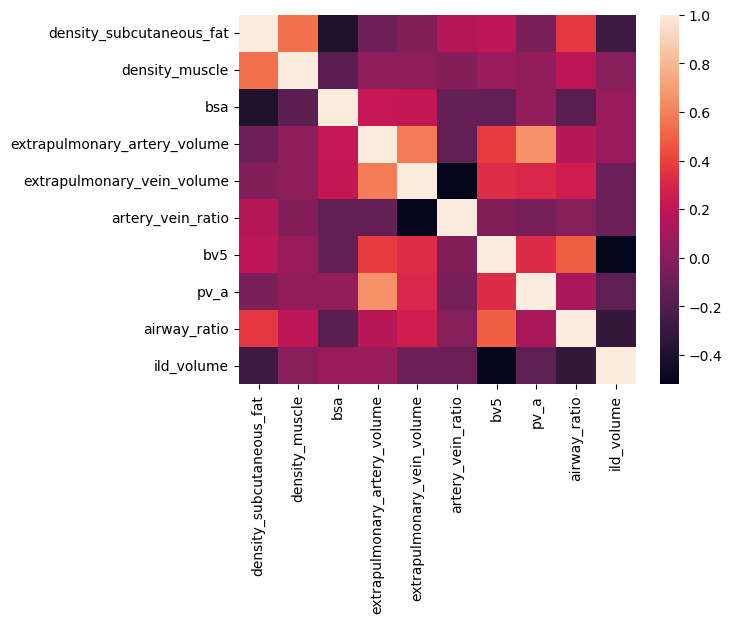

In [89]:
sns.heatmap(X[feat].corr())

In [86]:
ols = sm.OLS(y['total_clot_burden'], X[feat]).fit(cov_type='HC3')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      total_clot_burden   R-squared (uncentered):                   0.666
Model:                            OLS   Adj. R-squared (uncentered):              0.625
Method:                 Least Squares   F-statistic:                              23.53
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                    4.95e-20
Time:                        15:23:29   Log-Likelihood:                         -79.216
No. Observations:                  91   AIC:                                      178.4
Df Residuals:                      81   BIC:                                      203.5
Df Model:                          10                                                  
Covariance Type:                  HC3                                                  
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
density_subcutaneous_fat        -0.2803      0.112     -2.506      0.012      -0.500      -0.061
density_muscle                   0.2735      0.082      3.354      0.001       0.114       0.433
bsa                              0.2533      0.090      2.818      0.005       0.077       0.429
extrapulmonary_artery_volume    -0.3992      0.188     -2.120      0.034      -0.768      -0.030
extrapulmonary_vein_volume       0.4340      0.211      2.054      0.040       0.020       0.848
artery_vein_ratio               -0.2556      0.119     -2.153      0.031      -0.488      -0.023
bv5                             -0.3360      0.109     -3.077      0.002      -0.550      -0.122
pv_a                            -0.1541      0.089     -1.739      0.082      -0.328       0.020
airway_ratio                     0.2779      0.070      3.978      0.000       0.141       0.415
ild_volume                      -0.2338      0.101     -2.316      0.021      -0.432      -0.036
==============================================================================
Omnibus:                       36.742   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.526
Skew:                           1.361   Prob(JB):                     3.31e-23
Kurtosis:                       7.461   Cond. No.                         4.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

In [87]:
ols = sm.OLS(y['total_clot_burden'], X[remaining_features]).fit(cov_type='HC3')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      total_clot_burden   R-squared (uncentered):                   0.679
Model:                            OLS   Adj. R-squared (uncentered):              0.605
Method:                 Least Squares   F-statistic:                              10.11
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                    3.52e-13
Time:                        15:23:55   Log-Likelihood:                         -77.419
No. Observations:                  91   AIC:                                      188.8
Df Residuals:                      74   BIC:                                      231.5
Df Model:                          17                                                  
Covariance Type:                  HC3                                                  
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
volume_visceral_fat              0.0155      0.181      0.086      0.932      -0.340       0.371
density_subcutaneous_fat        -0.1851      0.150     -1.233      0.218      -0.479       0.109
density_intermuscular_fat       -0.1052      0.107     -0.984      0.325      -0.315       0.104
density_muscle                   0.1819      0.139      1.313      0.189      -0.090       0.454
mass_muscle                     -0.0185      0.134     -0.137      0.891      -0.282       0.245
density_bone                     0.0810      0.150      0.539      0.590      -0.213       0.375
bsa                              0.2110      0.160      1.315      0.188      -0.103       0.525
emphysema_volume_950hu           0.0171      0.100      0.171      0.864      -0.179       0.213
extrapulmonary_artery_volume    -0.4108      0.235     -1.747      0.081      -0.872       0.050
extrapulmonary_vein_volume       0.3506      0.221      1.587      0.112      -0.082       0.784
artery_vein_ratio               -0.2816      0.121     -2.325      0.020      -0.519      -0.044
bv5                             -0.3580      0.133     -2.699      0.007      -0.618      -0.098
pv_a                            -0.1701      0.091     -1.863      0.062      -0.349       0.009
heart_volume                     0.1055      0.130      0.812      0.417      -0.149       0.360
airway_ratio                     0.2771      0.083      3.332      0.001       0.114       0.440
ild_volume                      -0.1112      0.191     -0.582      0.561      -0.486       0.263
ild_ratio                       -0.1525      0.183     -0.832      0.405      -0.512       0.207
==============================================================================
Omnibus:                       31.461   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.602
Skew:                           1.208   Prob(JB):                     2.32e-17
Kurtosis:                       6.790   Cond. No.                         7.26
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
"""

## Feature Selection to ensure statistical significance

In [16]:
PVALUE_CUTOFF = 0.05

feature_set_dict = dict()
for feature_key, feature_option in tqdm(feature_options.items()):
    target_dict = dict()
    for target in tqdm(model_config.num_targets):
        feat_out, progression = backward_stepwise_selection(X[feature_option], np.array(y[target]).ravel(), PVALUE_CUTOFF)
        target_dict[target] = feat_out
    feature_set_dict[feature_key] = target_dict

composite1_dict = dict()
for body_key, cardio_key in zip(feature_set_dict['body'], feature_set_dict['cardio']):
    assert body_key == cardio_key
    composite1_dict[body_key] = feature_set_dict['body'][body_key] + feature_set_dict['cardio'][cardio_key]
feature_set_dict.update({'composite1': composite1_dict})
feature_set_dict.keys()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

dict_keys(['body', 'cardio', 'composite', 'composite1'])

In [17]:
feature_set_dict['body'].keys()

dict_keys(['total_clot_burden', 'centralartery', 'apical_rs1', 'posterior_rs2', 'anterior_rs3', 'lateral_rs4', 'medial_rs5', 'superior_rs6', 'medial_basal_rs7', 'anterior_basal_rs8', 'lateral_basal_rs9', 'posterior_basal_rs10', 'apical_ls1', 'posterior_ls2', 'anterior_ls3', 'superior_ls4', 'inferior_ls5', 'superior_ls6', 'anteromedial_basal_ls7_8', 'lateral_basal_ls9', 'posterior_basal_ls10'])

In [18]:
bwd_stepwise_df = pd.DataFrame()
for feature_key, feature_dict in tqdm(feature_set_dict.items()):
    for target, features in tqdm(feature_dict.items()):
            # Fit model
            X_temp = sm.add_constant(X[features])
            y_temp = y[target]
            model_sm, model_sk = fit_model(X_temp, y_temp)
    
            # Collect model/coef information
            temp_models = store_model_results(model_sm, model_sk, X_temp, y_temp)
            temp_coefs = store_coef_results(model_sm, y_temp)

            # Combine model and coef information
            temp_results = pd.concat([temp_models, temp_coefs], axis=1)
            temp_results = temp_results.reset_index()
            temp_results['model_dfn'] = temp_results['model_dfn'].apply('_'.join)
            temp_results['category'] = feature_key
            temp_results['controls'] = 'controls=NA'
            temp_results['selection_method'] = 'bwd_stepwise'
            temp_results.index = temp_results[['category', 'selection_method', 'y', 'controls']].apply('%'.join, axis=1)
            temp_results.index.name = 'Lookup'

            # Combine
            bwd_stepwise_df = pd.concat([bwd_stepwise_df, temp_results], axis=0)

bwd_stepwise_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

,y,model_dfn,nobs,shapiro_resid_pvalue,metric_train,metric_cv_mean,metric_cv_std,coef_bsa,coef_const,coef_mass_intermuscular_fat,...,signif_lung_volume,coef_airway_volume,pval_airway_volume,signif_airway_volume,coef_emphysema_volume_950hu,pval_emphysema_volume_950hu,signif_emphysema_volume_950hu,coef_density_visceral_fat,pval_density_visceral_fat,signif_density_visceral_fat
Lookup,,,,,,,,,,,,,,,,,,,,,
body%bwd_stepwise%total_clot_burden%controls=NA,total_clot_burden,const_volume_intermuscular_fat_mass_intermuscu...,91.0,3.100720e-06,0.186864,0.162690,0.334783,0.527531,0.0,-14.656587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body%bwd_stepwise%centralartery%controls=NA,centralartery,const_volume_intermuscular_fat_mass_intermuscu...,91.0,1.091054e-08,0.190303,0.167213,0.296215,0.461457,0.0,-19.671489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body%bwd_stepwise%apical_rs1%controls=NA,apical_rs1,const_volume_intermuscular_fat_bsa,91.0,2.626058e-09,0.104872,0.122851,128.979031,0.443876,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body%bwd_stepwise%posterior_rs2%controls=NA,posterior_rs2,const_volume_visceral_fat,91.0,1.059852e-13,0.007378,0.000000,153.674113,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body%bwd_stepwise%anterior_rs3%controls=NA,anterior_rs3,const_bsa,91.0,7.311946e-17,0.018785,0.053674,0.449423,0.137057,-0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Combine Univariate and Multivariable regression results

In [124]:
ols_results = pd.concat([univariate_results, multivariable_results], axis=0)
if COV_TYPE == 'robust':
    ols_results.to_csv('../output/regressions/ols_results_robust.csv')
elif COV_TYPE == 'clustered':
    ols_results.to_csv('../output/regressions/ols_results_clustered.csv')